# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle, os
from IPython.display import clear_output

In [2]:
from tqdm.auto import tqdm, trange
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
pd.options.display.max_colwidth = -1

from dsutils.ml import *

# Data

In [4]:
data1 = pd.read_csv('emails.csv')
data2 = pd.read_csv('sms.csv')
data3 = pd.read_csv('Youtube01-Psy.csv')
data4 = pd.read_csv('Youtube02-KatyPerry.csv')
data5 = pd.read_csv('Youtube03-LMFAO.csv')
data6 = pd.read_csv('Youtube04-Eminem.csv')
data7 = pd.read_csv('Youtube05-Shakira.csv')
data8 = pd.read_csv('spam_or_not_spam.csv')

## Integration

In [5]:
data = pd.DataFrame(columns=['Text', 'Spam'])

for i in trange(len(data1)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data1['text'][i].replace('Subject: ', '')],
        'Spam': [data1['spam'][i]]
    })])

for i in trange(len(data2)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data2['message'][i]],
        'Spam': [int(data2['label'][i] == 'spam')]
    })])

for i in trange(len(data3)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data3['CONTENT'][i]],
        'Spam': [data3['CLASS'][i]]
    })])

for i in trange(len(data4)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data4['CONTENT'][i]],
        'Spam': [data4['CLASS'][i]]
    })])
    
for i in trange(len(data5)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data5['CONTENT'][i]],
        'Spam': [data5['CLASS'][i]]
    })])

for i in trange(len(data6)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data6['CONTENT'][i]],
        'Spam': [data6['CLASS'][i]]
    })])  

for i in trange(len(data7)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data7['CONTENT'][i]],
        'Spam': [data7['CLASS'][i]]
    })])
    
for i in trange(len(data8)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data8['email'][i]],
        'Spam': [data8['label'][i]]
    })])    
    
data.drop_duplicates(inplace=True)
    
print('Done')
print(len(data))


Done
15497


In [6]:
(len(data[data['Spam'] == 0])/len(data[data['Spam'] == 1]))

3.7103343465045593

In [7]:
data = pd.concat([
    data[data['Spam'] == 1],
    data[data['Spam'] == 1],
    data[data['Spam'] == 1],
    data[data['Spam'] == 1].sample(frac=0.71),
    data[data['Spam'] == 0]
]).sample(frac=1.00)

# Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

In [9]:
class TextCleaner(BaseEstimator):
    
    def __init__(self, rsw=True, stm=False, lem=False):
        
        self.rsw = rsw
        self.stm = stm
        self.lem = lem
        
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        self.ps = PorterStemmer()
        self.wnl = WordNetLemmatizer()
        
    def fit(self, x, y=None):
        return self
    
    def spell_correct(self, text):
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"what's", "what is ", text) 
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"\0s", "0", text)    
        return text

    def remove_url(self, text):
        URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\\^`[\]]*)''')
        return URL_REGEX.sub(r' ', text)

    def remove_handles(self, text):
        HANDLES_REGEX = re.compile(r'@\S+')
        return HANDLES_REGEX.sub(r' ', text)

    def remove_incomplete_last_word(self, text):
        INCOMPLETE_LAST_WORD_REGEX = re.compile(r'\S+…')
        return INCOMPLETE_LAST_WORD_REGEX.sub(r' ', text )

    def remove_punc(self, text):
        return re.sub(r"\W", ' ', text)


    def remove_num(self, text):
        return re.sub(r"\d", ' ', text)

    def remove_extra_spaces(self, text):
        return re.sub(r"\s+", ' ', text).strip()

    def remove_shortwords(self, text): 
        return ' '.join(word for word in text.split() if len(word) > 2)

    def lower_case(self, text):
        return  text.lower()

    def remove_stopwords(self, text):
        return ' '.join(word for word in text.split() if word not in self.stop_words)

    def ps_stem(self, text):
        return ' '.join(self.ps.stem(word) for word in text.split())

    def wnl_lemmatize(self, text):
        return ' '.join(self.wnl.lemmatize(word) for word in text.split())

    def clean(self, x, rsw, stm, lem):
        x = str(x)
        x = self.remove_url(str(x))
        x = self.lower_case(str(x))
        x = self.spell_correct(str(x))
        x = self.remove_punc(str(x))
        x = self.remove_num(str(x))
        x = self.remove_extra_spaces(str(x))
        x = self.remove_shortwords(str(x))

        if rsw:
            x = self.remove_stopwords(str(x))
        if stm:
            x = self.ps_stem(str(x))
        if lem:
            x = self.wnl_lemmatize(str(x))
        return x
    
    def transform(self, x):
        x = map(lambda text: self.clean(text, self.rsw, self.stm, self.lem)  , x)
        x = np.array(list(x))
        return x

Mean Loss 0.5283665542090938 +- 0.00501891262449813


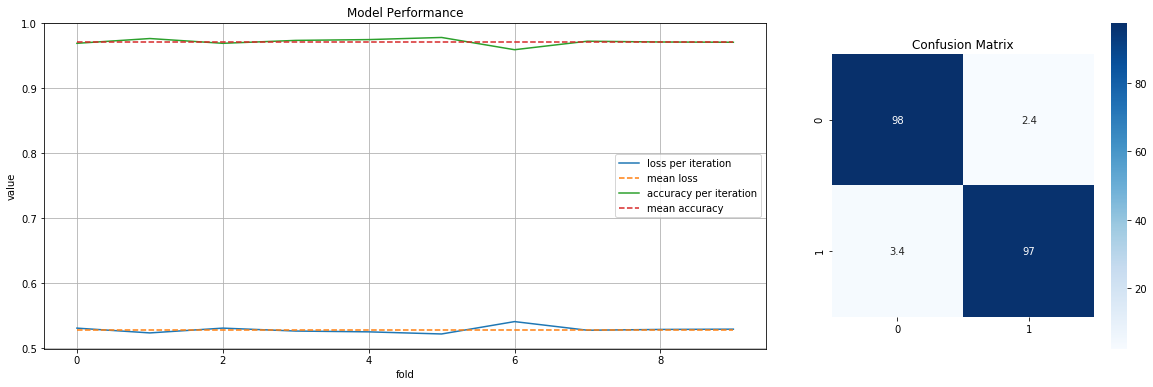

In [10]:
cleaner = TextCleaner()

vectorizer = TfidfVectorizer(smooth_idf=True)

model = VotingClassifier(estimators=[
    ('MNB', MultinomialNB()),
    ('BNB', BernoulliNB()),
    ('SGD-L1', SGDClassifier(loss='log', max_iter=100000, tol=0.001, penalty='l1', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-L2', SGDClassifier(loss='log', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-H1', SGDClassifier(loss='hinge', max_iter=100000, tol=0.001, penalty='l1', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-H2', SGDClassifier(loss='hinge', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-P2', SGDClassifier(loss='perceptron', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True,
                             class_weight='balanced', early_stopping=True)),
    ('LR-1', LogisticRegression(solver='liblinear', max_iter=100000, class_weight='balanced', random_state=101, 
                                warm_start=True)),
    ('LR-2', LogisticRegression(solver='lbfgs', max_iter=100000, class_weight='balanced', random_state=101, warm_start=True)),
    ('DT', DecisionTreeClassifier(random_state=101)),
], weights=[1, 1, 1, 1, 1, 36, 1, 1, 1, 1])

p = Pipeline([
    ('clean', cleaner),
    ('features', vectorizer),
    ('train', model)
])

p_performance, p_cm, p_model = train_model_on_vects(p, data['Text'].values, data['Spam'].astype(int).values)
print('Mean Loss', np.mean(p_performance['loss']), '+-', np.std(p_performance['loss']))

In [11]:
pickle.dump(p, open('SpamFilterPipeline.pkl', 'wb'))